# Analysis of Scenario 3: Load Test

## Imports

In [1]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import scikit_posthocs as sp

## Parameters

In [2]:
# hey with 8 cores, docker with 4 cores
RESULTS_DIR = Path("../results/20251128_005820/fixed")

# using 3 service instances
# RESULTS_DIR = Path("../results/20251128_160731/fixed")

## Load Data

In [3]:

# load all csv files in the results directory
csv_files = list(RESULTS_DIR.glob("*.csv"))


print(f"Found csv files: {len(csv_files)}")
for f in csv_files:
    print(" -", f.name)

# read data
def load_hey_csv(path: Path):
    df = pd.read_csv(path)
    # file name for example: haproxy_http_5000_10.csv (gateway_protocol_numberOfRequests_concurrency)
    parts = path.stem.split("_")
    gateway = parts[0]
    protocol = parts[1]
    numberOfRequests = parts[2]
    concurrency = parts[3]
    df["gateway"] = gateway
    df["protocol"] = protocol
    df["numberOfRequests"] = numberOfRequests
    df["concurrency"] = concurrency
    return df

df = pd.concat([load_hey_csv(f) for f in csv_files], ignore_index=True)

print(f"\nTotal records: {len(df):,}")
df.sample(random_state=42)

Found csv files: 24
 - haproxy_http_50000_50.csv
 - traefik_http_5000_1.csv
 - traefik_http_20000_50.csv
 - nginx_http_50000_50.csv
 - tyk_http_20000_50.csv
 - haproxy_http_5000_10.csv
 - tyk_http_50000_50.csv
 - nginx_http_20000_50.csv
 - traefik_http_5000_10.csv
 - traefik_http_50000_50.csv
 - haproxy_http_20000_50.csv
 - traefik_http_100000_50.csv
 - traefik_http_20000_10.csv
 - haproxy_http_100000_50.csv
 - tyk_http_5000_10.csv
 - tyk_http_100000_50.csv
 - nginx_http_5000_1.csv
 - tyk_http_20000_10.csv
 - nginx_http_5000_10.csv
 - tyk_http_5000_1.csv
 - nginx_http_100000_50.csv
 - haproxy_http_20000_10.csv
 - haproxy_http_5000_1.csv
 - nginx_http_20000_10.csv

Total records: 800,000


,response-time,DNS+dialup,DNS,Request-write,Response-delay,Response-read,status-code,offset,gateway,protocol,numberOfRequests,concurrency
212188,0.0005,0.0,0.0,0.0,0.0004,0.0,200,2.867,nginx,http,20000,50


## Response time to ms

In [4]:
df["response-time"] = df["response-time"] * 1000
df.sample()

,response-time,DNS+dialup,DNS,Request-write,Response-delay,Response-read,status-code,offset,gateway,protocol,numberOfRequests,concurrency
26216,1.9,0.0003,0.0002,0.0,0.0016,0.0,200,7.6956,haproxy,http,50000,50


# Response Time across Gateways

In [5]:
# Unified gateway color map
GATEWAY_COLORS = {
    "caddy": "red",
    "haproxy": "green",
    "traefik": "blue",
    "tyk": "orange",
    "nginx": "purple",
}

In [6]:

def plot_response_time_boxplot(df_plot: pd.DataFrame):
    # all gateways in dataframe
    gateways = sorted(df_plot['gateway'].unique())

    # Boxplot with all gateways
    fig, ax = plt.subplots(figsize=(8, 6))

    data_per_gateway = [df_plot[df_plot['gateway'] == gw]['response-time'] for gw in gateways]
    bp = ax.boxplot(
        data_per_gateway,
        tick_labels=gateways,
        patch_artist=True,
        medianprops=dict(color="black"),
        boxprops=dict(facecolor="lightblue", alpha=0.7),
        whiskerprops=dict(color="gray"),
        capprops=dict(color="gray"),
        # showfliers=False,
    )

    # colored boxes
    for patch, gw in zip(bp['boxes'], gateways):
        patch.set_facecolor(GATEWAY_COLORS.get(gw, "lightgray"))
        patch.set_alpha(0.6)

    # log scale prevents minimizing box
    ax.set_yscale("log")

    # ax.set_title(f"Response Time Comparison Between Gateways ({len(df_plot):,} requests, concurrency={df_plot['concurrency'].iloc[0]})")
    # ax.set_xlabel("Gateway")
    ax.set_ylabel("Response Time (ms, log)")
    ax.grid(True, linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.savefig(f"findings-scenario-3-requests-{df_plot['numberOfRequests'].iloc[0]}-concurrency-{df_plot['concurrency'].iloc[0]}.png", dpi=300)
    plt.show()

# 5000 Requests each / concurrency 1

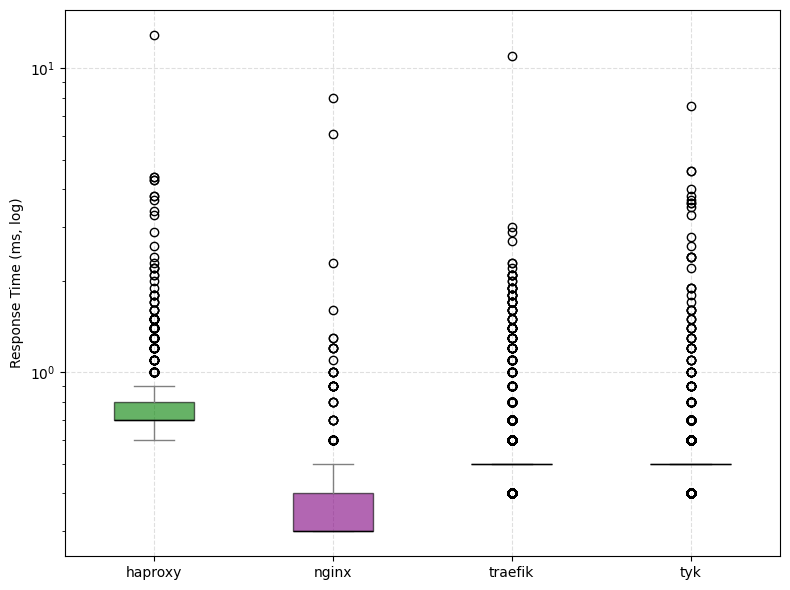

In [7]:
df_plot = df[(df['numberOfRequests'] == "5000") & (df['concurrency'] == "1")]
plot_response_time_boxplot(df_plot)

# 5000 Requests each / concurrency 10

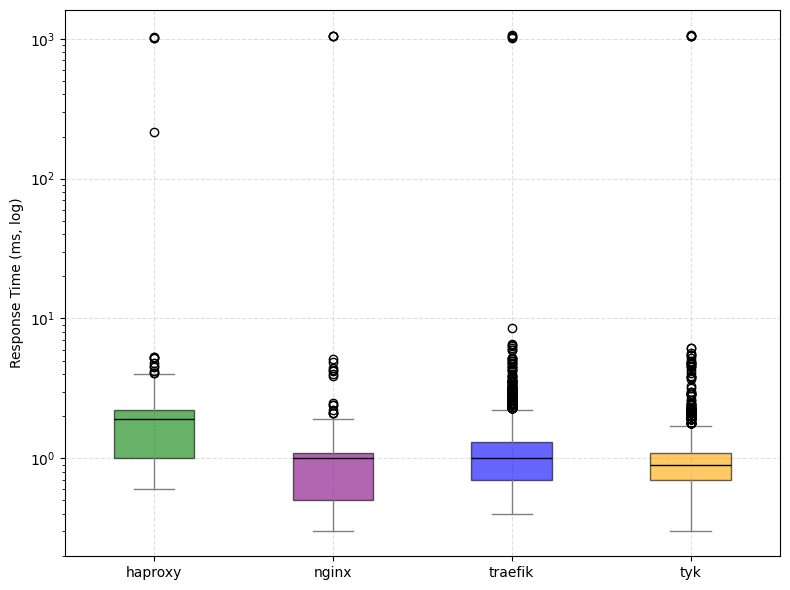

In [8]:
df_plot = df[(df['numberOfRequests'] == "5000") & (df['concurrency'] == "10")]
plot_response_time_boxplot(df_plot)

# 20,000 Requests each / concurrency 10

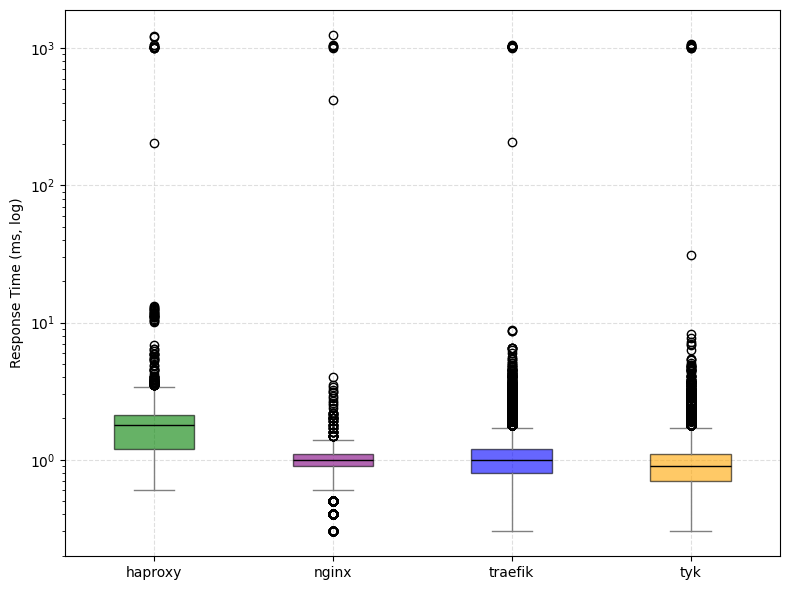

In [9]:
df_plot = df[(df['numberOfRequests'] == "20000") & (df['concurrency'] == "10")]
plot_response_time_boxplot(df_plot)

# 20,000 Requests each / concurrency 50

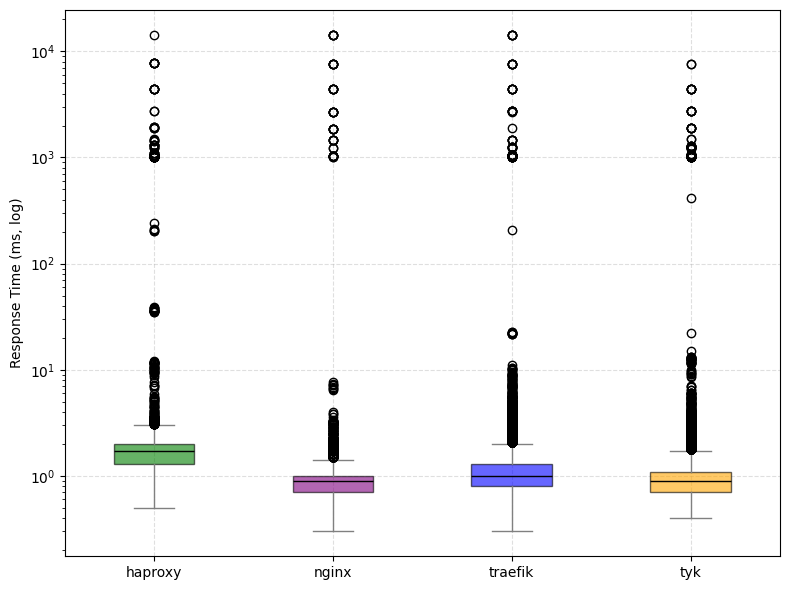

In [10]:
df_plot = df[(df['numberOfRequests'] == "20000") & (df['concurrency'] == "50")]
plot_response_time_boxplot(df_plot)

# 50,000 Requests each / concurrency 50

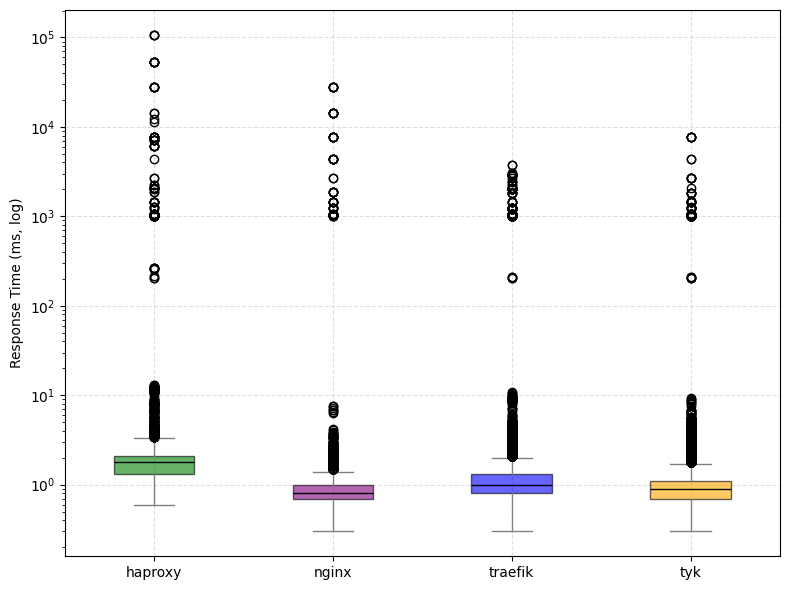

In [11]:
df_plot = df[(df['numberOfRequests'] == "50000") & (df['concurrency'] == "50")]
plot_response_time_boxplot(df_plot)

# 100,000 Requests each / concurrency 50

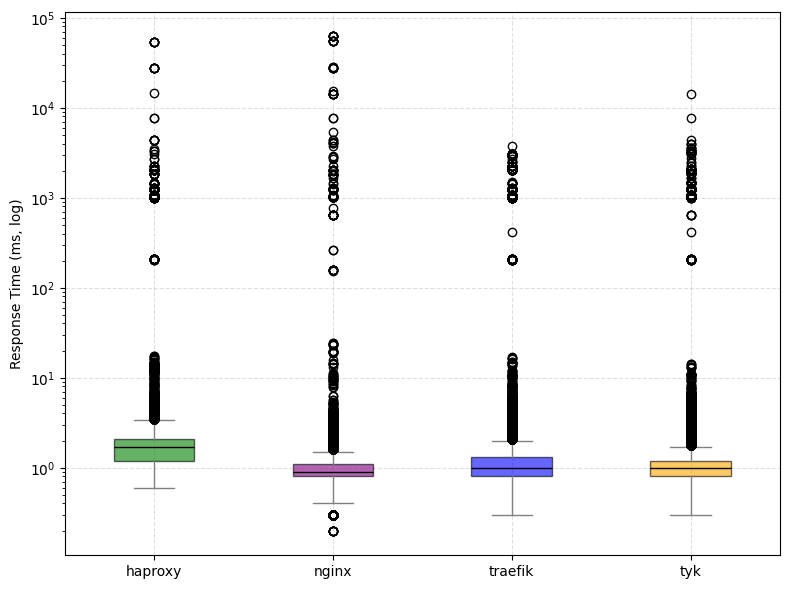

In [12]:
df_plot = df[(df['numberOfRequests'] == "100000") & (df['concurrency'] == "50")]
plot_response_time_boxplot(df_plot)

In [13]:
# dataframe summary for this scenario
summary = df.groupby(['gateway', 'numberOfRequests', 'concurrency'])['response-time'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()
summary = summary.sort_values(by=['numberOfRequests', 'concurrency', 'gateway'])
display(summary)

,gateway,numberOfRequests,concurrency,mean,median,std,min,max
0,haproxy,100000,50,11.409968,1.7,449.710714,0.6,53953.4
6,nginx,100000,50,12.375436,0.9,694.952035,0.2,62056.7
12,traefik,100000,50,7.756765,1.0,95.964796,0.3,3723.5
18,tyk,100000,50,6.776493,1.0,104.526105,0.3,14315.6
1,haproxy,20000,10,2.365375,1.8,25.897800,0.6,1229.0
7,nginx,20000,10,1.300605,1.0,18.751789,0.3,1249.4
13,traefik,20000,10,1.800385,1.0,27.183287,0.3,1047.3
19,tyk,20000,10,1.429670,0.9,21.868540,0.3,1063.9
2,haproxy,20000,50,10.573565,1.7,198.568912,0.5,14157.0
8,nginx,20000,50,10.362965,0.9,280.386142,0.3,14295.9


# Significance Testing of selected Combinations: Students T-test

## T-test for 5,000 requests and concurrency 10

In [14]:
df_plot = df[(df['numberOfRequests'] == "5000") & (df['concurrency'] == "10")]

# perform pairwise t-tests
ttest_results = sp.posthoc_ttest(
    df_plot,
    val_col="response-time",
    group_col="gateway",
    equal_var=False,
    sort=True
)

print("T-test p-values matrix")

print("actual values:")
display(ttest_results)
print("rounded values:")
display(ttest_results.round(3))
print("significant differences matrix (p < 0.05):")
display(ttest_results < 0.05)   

# check for significant differences
print("Significant differences (p < 0.05):")
for a, b in itertools.combinations(df_plot["gateway"].unique(), 2):
    p = ttest_results.loc[a, b]
    if p < 0.05:
        print(f"{a} vs {b}: p={p:.20f}")

T-test p-values matrix
actual values:


,haproxy,nginx,traefik,tyk
haproxy,1.000000,0.091244,0.444296,0.315451
nginx,0.091244,1.000000,0.426266,0.584952
traefik,0.444296,0.426266,1.000000,0.819475
tyk,0.315451,0.584952,0.819475,1.000000


rounded values:


,haproxy,nginx,traefik,tyk
haproxy,1.000,0.091,0.444,0.315
nginx,0.091,1.000,0.426,0.585
traefik,0.444,0.426,1.000,0.819
tyk,0.315,0.585,0.819,1.000


significant differences matrix (p < 0.05):


,haproxy,nginx,traefik,tyk
haproxy,False,False,False,False
nginx,False,False,False,False
traefik,False,False,False,False
tyk,False,False,False,False


Significant differences (p < 0.05):


## T-test for 50,000 requests and concurrency 50

In [15]:
df_plot = df[(df['numberOfRequests'] == "50000") & (df['concurrency'] == "50")]

# perform pairwise t-tests
ttest_results = sp.posthoc_ttest(
    df_plot,
    val_col="response-time",
    group_col="gateway",
    equal_var=False,
    sort=True
)

print("T-test p-values matrix")

print("actual values:")
display(ttest_results)
print("rounded values:")
display(ttest_results.round(3))
print("significant differences matrix (p < 0.05):")
display(ttest_results < 0.05)

# check for significant differences
print("Significant differences (p < 0.05):")
for a, b in itertools.combinations(df_plot["gateway"].unique(), 2):
    p = ttest_results.loc[a, b]
    if p < 0.05:
        print(f"{a} vs {b}: p={p:.6f}")

T-test p-values matrix
actual values:


,haproxy,nginx,traefik,tyk
haproxy,1.000000,0.002172,0.000575,0.000363
nginx,0.002172,1.000000,0.452802,0.259274
traefik,0.000575,0.452802,1.000000,0.340463
tyk,0.000363,0.259274,0.340463,1.000000


rounded values:


,haproxy,nginx,traefik,tyk
haproxy,1.000,0.002,0.001,0.000
nginx,0.002,1.000,0.453,0.259
traefik,0.001,0.453,1.000,0.340
tyk,0.000,0.259,0.340,1.000


significant differences matrix (p < 0.05):


,haproxy,nginx,traefik,tyk
haproxy,False,True,True,True
nginx,True,False,False,False
traefik,True,False,False,False
tyk,True,False,False,False


Significant differences (p < 0.05):
haproxy vs nginx: p=0.002172
haproxy vs tyk: p=0.000363
haproxy vs traefik: p=0.000575
